In [18]:
import math
import pandas as pd
from tqdm.notebook import tqdm as tqdm
# from transformers import pipeline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from data_utils import load_reddit_data
from utils import set_pandas_display_options

In [19]:
%load_ext autoreload
%autoreload 2   

In [20]:
set_pandas_display_options()

In [21]:
# load corpus
df = load_reddit_data()

# Prepare corpus

In [22]:
# remove missings
df = df.dropna(subset = "selftext")

# filter corpus
df = df[df["removed"] != 1]
df = df[df["author"] != "rBitcoinMod"]
df = df[df["num_comments"] > 10]


In [23]:
df.shape

(7978, 25)

In [24]:
# convert to datetime
df["datetime"] = pd.to_datetime(df["created"], unit="s")\

# Set 'datetime' column as the index
# assert len(df["datetime"].unique()) == df.shape[0]
# df.set_index('datetime', inplace=True, drop = True) # dont do this as datetime is not unique

# Relevance of posts
Classify whether posts are related to **bitcoin trading**

Mistral LLM automatic tagging

In [25]:
# mistral model

# mist = mistral_relevant_text_identification(df, "selftext")
# mist.to_csv("mistral_tagging.csv", index=False)

# load checkpoint
mist = pd.read_csv("bitcoin_2022/mistral_tagging_full.csv")

simple keyword search

In [26]:
KW_BITCOIN = ["bitcoin", "btc"]
KW_TRADING = ["trading", "trade", "market", "price", "value", "money", "indicator", "future", "derivative", "news",
              "invest", "buy", "bought", "sell", "sold", "win", "won", "bull", "bear", "pump", "dump",
              "hodl", "moon", "walls", "bagholder", "whale", "fomo"]
# TODO: are wallet posts trading related?
# KW_WALLET = ["wallet"]

df["contains_kw_bitcoin"] = df["selftext"].str.lower().str.contains("|".join(KW_BITCOIN))
df["contains_kw_trading"] = df["selftext"].str.lower().str.contains("|".join(KW_TRADING))
# df["contains_kw_wallet"] = df["selftext"].str.lower().str.contains("|".join(KW_WALLET))
df["contains_kw_bitcoin_trading"] = df["contains_kw_bitcoin"] & df["contains_kw_trading"] # & ~df["contains_kw_wallet"]

In [27]:
df["contains_kw_bitcoin_trading"].value_counts()

contains_kw_bitcoin_trading
True     4029
False    3949
Name: count, dtype: int64

In [28]:
# df["selftext"].str.split(" ").explode().value_counts().head(100)

In [29]:
# df[["contains_kw_bitcoin_trading", "selftext"]].head()

compare performance: expect mistral to positively classify finds of keyword search 

In [30]:
df["submission"] = df["submission"].astype(str)
mist["submission"] = mist["submission"].astype(str)
bench = pd.merge(df, mist[["submission", "mistral_tagging"]], on="submission")

In [31]:
bench.loc[bench["contains_kw_bitcoin_trading"], "mistral_tagging"].value_counts(dropna=False)   

mistral_tagging
0    3893
1     136
Name: count, dtype: int64

# Sentiment of posts
Calculate sentiment label and score 

huggingface/distilroberta

In [2]:
# MODEL = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
# sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

def remove_special_chars(text):
    return ''.join(e for e in text if e.isalnum() or e.isspace())

# sentiments_label = []
# sentiments_score = []
# for txt in tqdm(df["selftext"].values):
#     txt = remove_special_chars(txt)
#     try:
#         sentiment = sentiment_task(txt)
#         sentiments_label.append(sentiment[0]["label"])
#         sentiments_score.append(sentiment[0]["score"])
#     except Exception as e:
#         sentiments_label.append("N/A")
#         sentiments_score.append(0)

# load checkpoint
roberta_sent = pd.read_csv("bitcoin_2022/sentiment.csv")

In [ ]:
roberta_sent["sentiment_label"].value_counts()

sentiment_label
neutral     12655
positive     1524
negative     1393
Name: count, dtype: int64

nltk + vaderSentiment

In [ ]:
# nltk.download('all')

In [63]:
# create preprocess_text function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

# apply the function df

df['selftext_processed'] = df['selftext'].apply(preprocess_text)

In [40]:
# # work with raw categories

# # initialize NLTK sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()

# # get sentiment scores
# df["sentiment_scores_vader"] = df['selftext_processed'].apply(analyzer.polarity_scores)

# # get maximum score label
# def get_sentiment_label(scores):
#     del scores["compound"]
#     label = max(scores, key=scores.get)
#     return label
# df["sentiment_label_vader"] = df["sentiment_scores_vader"].apply(get_sentiment_label)

# # get score for maximum scored label
# df["sentiment_score_vader"] = df[["sentiment_scores_vader", "sentiment_label_vader"]].apply(lambda x: x["sentiment_scores_vader"][x["sentiment_label_vader"]], axis=1) 

In [64]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# get sentiment scores
df["sentiment_scores_vader"] = df['selftext'].apply(analyzer.polarity_scores)
df["sentiment_scores_vader_processed_text"] = df['selftext_processed'].apply(analyzer.polarity_scores)

# extract compound score: https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#about-the-scoring
df["sentiment_compound_label_vader"] = df["sentiment_scores_vader"].apply(lambda x: 1 if x["compound"] >= 0.05 else (-1 if x["compound"]<=-0.05 else 0))
df["sentiment_compound_label_vader_processed_text"] = df["sentiment_scores_vader_processed_text"].apply(lambda x: 1 if x["compound"] >= 0.05 else (-1 if x["compound"]<=-0.05 else 0))

In [65]:
df["sentiment_compound_label_vader_processed_text"].value_counts()

sentiment_compound_label_vader_processed_text
 1    5264
-1    1835
 0     879
Name: count, dtype: int64

In [41]:
df["sentiment_compound_label_vader"].value_counts()

sentiment_compound_label_vader
 1    5040
-1    2044
 0     894
Name: count, dtype: int64

In [45]:
# df[df["sentiment_compound_label_vader"]==0] 

In [46]:
# df.to_csv("bitcoin_2022/sentiment_vader.csv")
# df = pd.read_csv("bitcoin_2022/sentiment_vader.csv")

Human Eval of sentiment analysis

In [ ]:
eval_full = pd.merge(
    df.loc[
        # filter on bitcoin trading
        df["contains_kw_bitcoin_trading"], ["submission", "selftext", "contains_kw_bitcoin_trading", "selftext_processed", "sentiment_scores_vader", "sentiment_label_vader", "sentiment_score_vader"]], 
    roberta_sent[["submission", "sentiment_label", "sentiment_score"]], on=["submission"], how="inner")

In [ ]:
n_sample = 100
eval_template = eval_full[["submission", "selftext"]].sample(n_sample).copy()
eval_template["human_label"] = pd.NA

In [ ]:
# import math
# n_splits = 2
# for i in range(2):
#     split_size = math.floor(n_sample / n_splits)
#     eval_template.iloc[split_size*i : split_size*(i+1)].to_csv(f"bitcoin_2022/human_sent_eval_{i}.csv", index=False)

Compare sentiment algorithms with human performance

In [47]:
df_sent_hum = pd.concat([
    pd.read_csv("bitcoin_2022/human_sent_eval_0_labeled.csv"),
    pd.read_csv("bitcoin_2022/human_sent_eval_1_labeled.csv"),
], axis=0)

assert pd.isna(df_sent_hum["human_label"]).sum() == 0
assert len(set(df_sent_hum["human_label"].unique()) - {1,0,-1}) == 0

In [48]:
roberta_sent = pd.read_csv("bitcoin_2022/sentiment.csv")
vader_sent = pd.read_csv("bitcoin_2022/sentiment_vader.csv")

In [49]:
vader_sent.head()

,Unnamed: 0,submission,subreddit,author,created,retrieved,edited,pinned,archived,locked,...,selftext,thumbnail,shortlink,datetime,contains_kw_bitcoin,contains_kw_trading,contains_kw_bitcoin_trading,sentiment_scores_vader,sentiment_compound_score_vader,sentiment_compound_label_vader
0,6,rt7qa5,bitcoin,SilverAndAlgorand,1640998555,1641140399,0,0,0,0,...,"I only have .03 btc but I still feel early as I'm the only one in my family or friendgroup to have any btc.\n\nIf you, in the start of 2022, know enough about BTC to have some already, you're EARLY. I know we're all sad we didn't buy at .o2 cents (or whatever it was) but it's NEVER too late to start making better decisions. \n\nSo here's to all my Sat Stackers who are slowly, humbly, going to make it. \n\nCheers! Here's to BTC at any cost!",self,https://redd.it/rt7qa5,2022-01-01 00:55:55,True,True,True,"{'neg': 0.044, 'neu': 0.866, 'pos': 0.091, 'compound': 0.6634}",0.6634,1
1,23,rta3p4,bitcoin,Still_Hat6758,1641006460,1641140399,0,0,0,0,...,"Just a genuine question, I’ve googled biggest bitcoin wallets and I could only see Binance and a few other exchanges at the top. With 1 person in the billions but no where near the amount Satoshi has which I heard is 1million bitcoins? Anyway are his bitcoins counted as lost? Or still part of the supply? If it was factually announced they were lost forever somehow this would surge price because of the [law of demand](https://www.investopedia.com/terms/l/law-of-supply-demand.asp). Also would it be plausible for him to have split his bitcoins across multiple wallets and drain each wallet individually? I understand transaction history has Time stamps but I’m not sure if that was a thing in 2010\n\n So my question is Satoshi are you dead and if your not dead where are your bitcoins?",self,https://redd.it/rta3p4,2022-01-01 03:07:40,True,True,True,"{'neg': 0.169, 'neu': 0.822, 'pos': 0.01, 'compound': -0.9766}",-0.9766,-1
2,32,rtb773,bitcoin,train83,1641010349,1641140399,0,0,0,0,...,If people see the value going up then why is it a must as someone who’s not invested in Bitcoin to wanna do it now. Wouldn’t other crypto coins be more valuable to those who haven’t yet.,self,https://redd.it/rtb773,2022-01-01 04:12:29,True,True,True,"{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'compound': 0.6997}",0.6997,1
3,43,rtd46j,bitcoin,ghhtedcw5,1641017483,1641140399,0,0,0,0,...,"Thank god it is on sale, idk that I could take it if I had to pay so much for it this soon.",self,https://redd.it/rtd46j,2022-01-01 06:11:23,False,False,False,"{'neg': 0.115, 'neu': 0.697, 'pos': 0.189, 'compound': 0.4215}",0.4215,1
4,47,rtece7,bitcoin,buddhistdoc9,1641022446,1641140396,0,0,0,0,...,"I bought $1,000 AUD in BTC on 29th Jan 2021.\n\n[https://www.blockchain.com/btc/address/1GGqWYmYK78xEVxe9Xm6Fm8d1gd9rYMn9p](https://www.blockchain.com/btc/address/1GGqWYmYK78xEVxe9Xm6Fm8d1gd9rYMn9p)\n\nWhen I try to access the bitcoin wallet I can't.\n\nCan anyone help with this?\n\nThanks",self,https://redd.it/rtece7,2022-01-01 07:34:06,True,True,True,"{'neg': 0.083, 'neu': 0.81, 'pos': 0.107, 'compound': 0.1635}",0.1635,1


In [50]:
roberta_sent["sentiment_roberta"] = roberta_sent["sentiment_label"].map({"positive":1, "neutral":0, "negative":-1})
# vader_sent["sentiment_vader"] = vader_sent["sentiment_label_vader"].map({"pos":1, "neu":0, "neg":-1})
vader_sent["sentiment_vader"] = vader_sent["sentiment_compound_label_vader"] #.map({"pos":1, "neu":0, "neg":-1})

In [51]:
from functools import reduce
data_frames = [df_sent_hum, roberta_sent[["submission", "sentiment_roberta"]], vader_sent[["submission", "sentiment_vader"]]]
df_sent_comp = reduce(lambda  left,right: pd.merge(left, right, on=['submission'], how='inner'), data_frames)

In [52]:
assert df_sent_comp.isna().sum().sum() == 2 # roberta missings
df_sent_comp = df_sent_comp.dropna()

In [53]:
df_sent_comp.shape

(98, 5)

In [54]:
df_sent_comp["human_label"].value_counts()

human_label
 0.0    39
-1.0    30
 1.0    29
Name: count, dtype: int64

In [57]:
df_sent_comp["sentiment_roberta"].value_counts()

sentiment_roberta
 0.0    71
 1.0    20
-1.0     7
Name: count, dtype: int64

In [58]:
df_sent_comp["sentiment_vader"].value_counts()

sentiment_vader
 1    72
-1    22
 0     4
Name: count, dtype: int64

In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=df_sent_comp["human_label"], y_pred=df_sent_comp["sentiment_roberta"]),\
accuracy_score(y_true=df_sent_comp["human_label"], y_pred=df_sent_comp["sentiment_vader"])

(0.5408163265306123, 0.42857142857142855)

In [60]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
labels = [-1, 0, 1]

<Axes: title={'center': 'human vs. roberta'}>

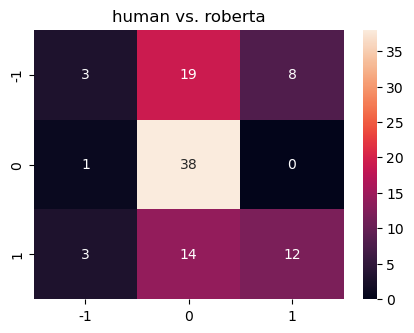

In [69]:
cm = confusion_matrix(
    y_true=df_sent_comp["human_label"], 
    y_pred=df_sent_comp["sentiment_roberta"],
    labels=labels
)

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (5,3.5))
plt.title("human vs. roberta")
sn.heatmap(df_cm, annot=True)

<Axes: title={'center': 'human vs. vader'}>

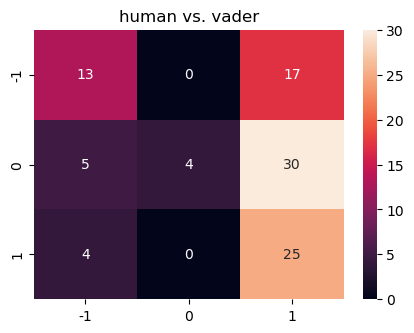

In [62]:
cm = confusion_matrix(
    y_true=df_sent_comp["human_label"], 
    y_pred=df_sent_comp["sentiment_vader"],
    labels=labels
)

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (5,3.5))
plt.title("human vs. vader")
sn.heatmap(df_cm, annot=True)